In [ ]:
import os
import sys

import hydra
import numpy as np
import pandas as pd
from ax import (Arm, ChoiceParameter, ComparisonOp, Data, FixedParameter,
                Metric, Models, Objective, OptimizationConfig,
                OutcomeConstraint, Parameter, ParameterType, RangeParameter,
                Runner, SearchSpace, SimpleExperiment)

sys.path.append(r"C:\Users\jesga\OneDrive\Desktop\NeuroscienceLeuven\Code\Decodingv7")
sys.path.append(r"C:\Users\jesga\OneDrive\Desktop\NeuroscienceLeuven\Code\tnsbmi")
sys.path.append(r"C:\Users\jesga\OneDrive\Desktop\NeuroscienceLeuven\Code\tnspython")
import json
import logging
import warnings

from ax import save
from ax.storage.runner_registry import register_runner
from decoding.data import get_alignOn,  get_timesteps
from decoding.parameters import Preprocessing_DefaultParameters
from modeling.defaults import CLASSIFIERS, FEATURE_EXTRACTORS, PREPROCESSORS
from modeling.pipeline_builder import PipelineBuilder
from modeling.pipelines import DecoderPipeline, ExplorationPipeline
from omegaconf import DictConfig, OmegaConf
from preprocessing.ratesTransformer import RatesTransformer
from preprocessing.reachTuningTransformer import ReachTuningTransformer
from sklearn.model_selection import train_test_split
from tnsbmi import dataconversion
from tnsbmi.binning import Bin
from ax import load
import pickle
from optimization.utils import SearchSpaceGen
from ax.service.ax_client import AxClient
import seaborn as sns

In [2]:
def GetBestParameters(ax_client, metric):
    experiment = ax_client.experiment
    trials_df =  experiment.fetch_data().df
    df = trials_df[trials_df.metric_name == metric]
    best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
    best_arm = experiment.arms_by_name[best_arm_name]
    return best_arm.parameters

# Parameters

In [3]:
root_dir = "C:\\Users\\jesga\\OneDrive\\Desktop\\NeuroscienceLeuven\\Code\\outputs\\different_positions\\vgrasp_Sky_20200819_1137_B_trials\\Basic_RF\\RF_Tint_f1_weighted\\200\\2020-12-17_19-57-01"
metric = "accuracy"
tint = 200
tskip = 150
k = 5

In [4]:
# Parameters
root_dir = "C:\\Users\\jesga\\OneDrive\\Desktop\\NeuroscienceLeuven\\Code\\outputs\\different_objects\\vgrasp_Sky_20200928_1312_B_trials\\Basic_RF\\RF_Tint_f1_weighted\\200\\2020-12-17_19-11-00"
metric = "accuracy"
tint = 200
tskip = 150
k = 5


# Loading Opt Results

In [5]:
config_path = os.path.join(root_dir,".hydra","config.yaml")
cfg = OmegaConf.load(config_path)
restore_path = os.path.join(root_dir,"ax_client_snapshot.json")
ax_client = AxClient.load_from_json_file(restore_path) 

[INFO 12-18 14:08:10] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


# Data Set-Up

In [6]:
# Load data
trials, _ = dataconversion.LoadLastNTrials([cfg.data.data_path], 1000)
labels  = np.array([trial.targetObject for trial in trials], dtype = np.int32)

# Splitting train/test
seed = 0
seed = np.random.seed(seed)
trials_train, trials_test, y_train, y_test = train_test_split(trials,
                                                    labels,
                                                    test_size=0.33,
                                                    random_state= seed)
data_dict = {
    "train": {
        "X": trials_train, "y": y_train
    },
    "test": {
        "X": trials_test, "y": y_test
    }
}
trial_params = {
    'alignmentEvent': 'Target',
    'timeBeforeEvent': -tskip,
    'timeAfterEvent': tint + tskip ,
    'binWidth': tint,
    'n_bins"': 1
}
labels_set = set(labels)

In [7]:
# Basic trial params (e.g. Cue, timebeforecue, etc)
available_steps = {**PREPROCESSORS, **FEATURE_EXTRACTORS, **CLASSIFIERS}            
# Define pipeline
model_pipeline = PipelineBuilder(available_steps)
model_pipeline = model_pipeline.fit(cfg.pipeline.pipeline_arch)
# Fit pipeline
model = DecoderPipeline(model_pipeline,
                        metric = cfg.metric_dict).set_data(trials_train, y_train)
opt_parameters = GetBestParameters(ax_client, metric)
# Modify tint
opt_parameters["preprocessing__rates_comp__t_int"] = tint
model = model.init_model(opt_parameters).fit(trials_train, y_train)

# Exploration Pipeline

In [8]:
exp_pipe = ExplorationPipeline(model, data_dict)

# Preprocessing

In [9]:
step = "preprocessing__anova_filter" # anova_filter --> anova_feature_selector
df_preprocessing = exp_pipe.processed_data_df(step)

In [10]:
def col_filter(df, k, hue_cols):
    cols = df.columns
    components = [col for col in cols if type(col)==int]
    if(len(components) > 10):
        features_to_use  = components[:k] 
    else:
        features_to_use = components
    cols_to_use = features_to_use + hue_cols
    return cols_to_use

In [11]:
cols_to_use = col_filter(df_preprocessing, k, [])

# Split Plots

In [12]:
def split_plots(df, cols_to_use, data_dict):
    for split in data_dict.keys():
        # filter
        filter_cond = df["split"] == split
        dist_plot = sns.pairplot(df[filter_cond],
                     hue= "label",
                     vars = cols_to_use,
                     corner = True,
                     diag_kind = "hist",
                     diag_kws = {
                         "stat":"density",
                         "common_norm":False
                     })
        dist_plot.fig.suptitle(f"Distributions for {split}")

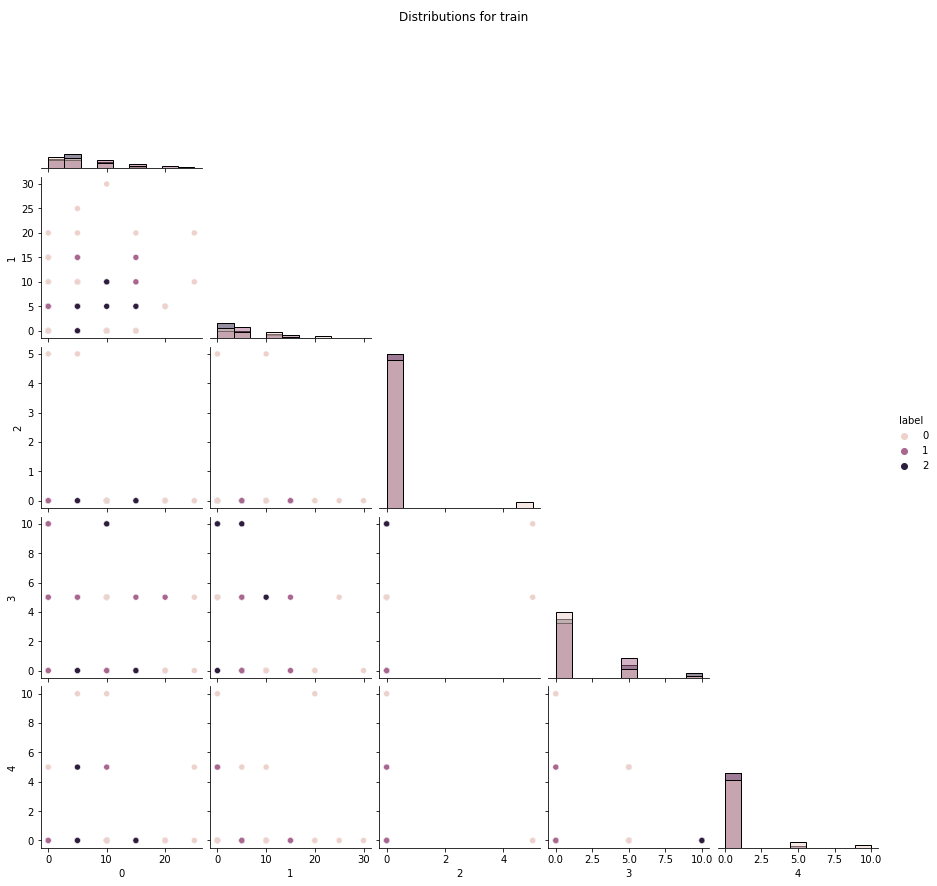

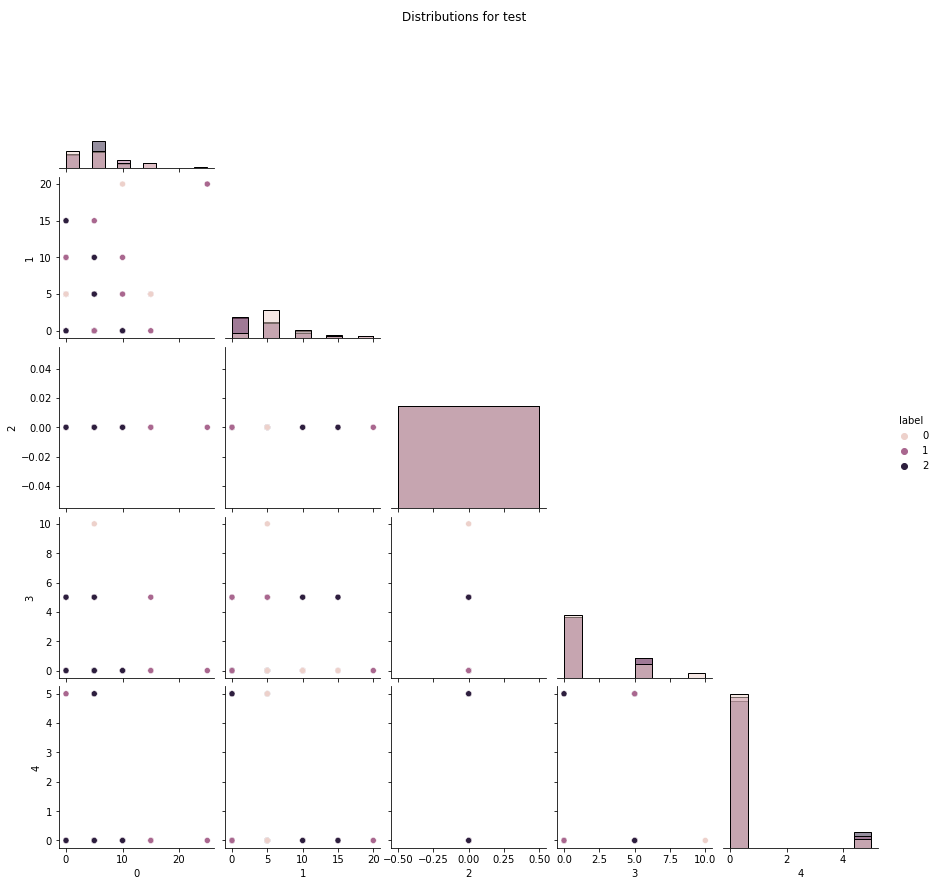

In [13]:
split_plots(df_preprocessing, cols_to_use, data_dict)

# Class Plots

In [14]:
def class_plots(df, cols_to_use, labels_set):
    for label in labels_set:
        # filter
        filter_cond = df["label"] == label
        dist_plot = sns.pairplot(df[filter_cond],
                     hue= "split",
                     vars = cols_to_use,
                     corner = True,
                     diag_kind = "hist",
                     diag_kws = {
                         "stat":"density",
                         "common_norm":False
                     })

        dist_plot.fig.suptitle(f"Distributions for {label}")

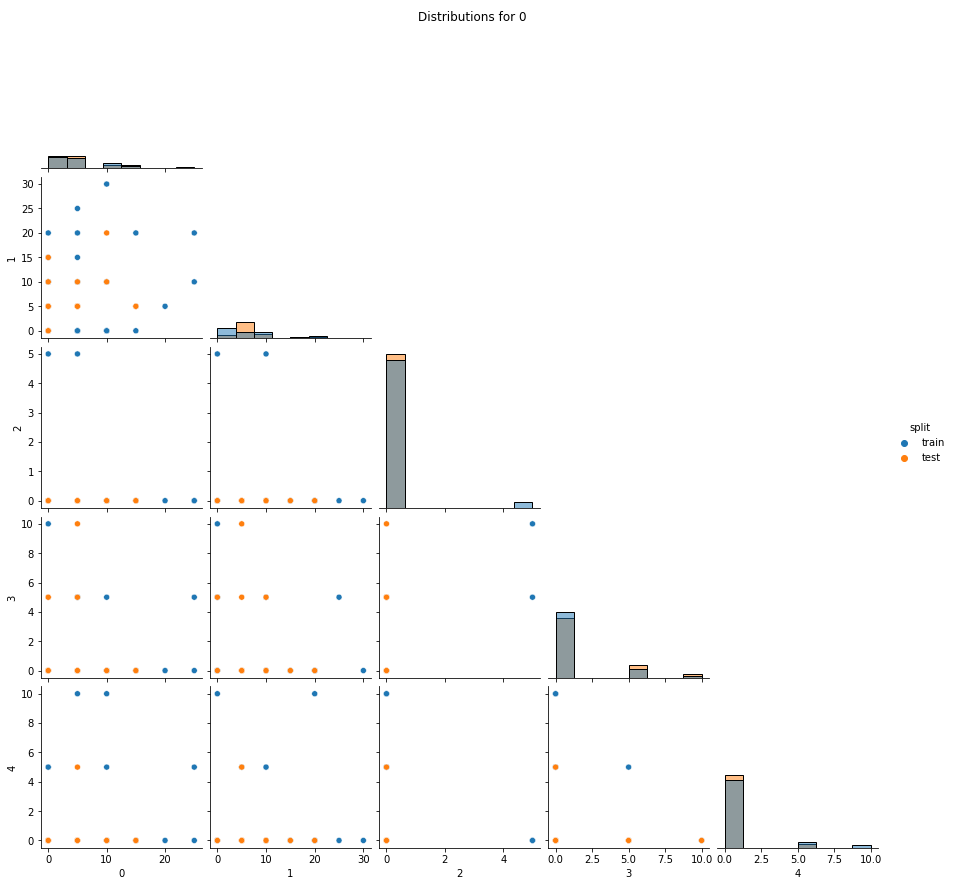

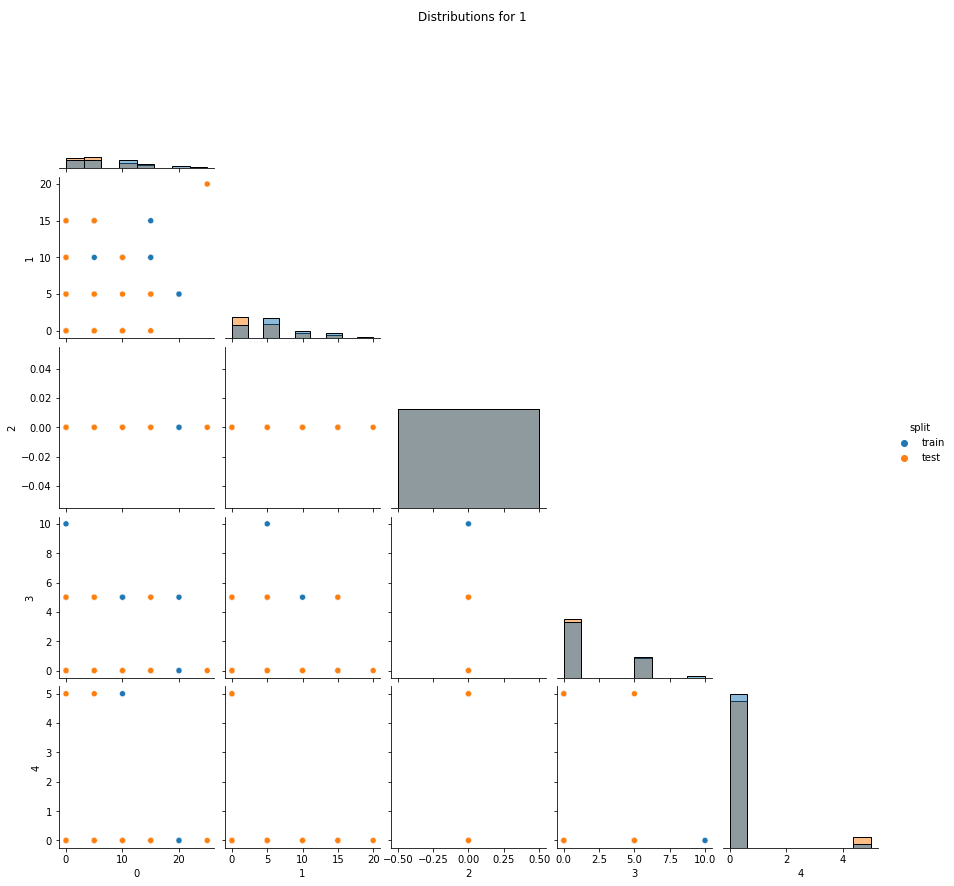

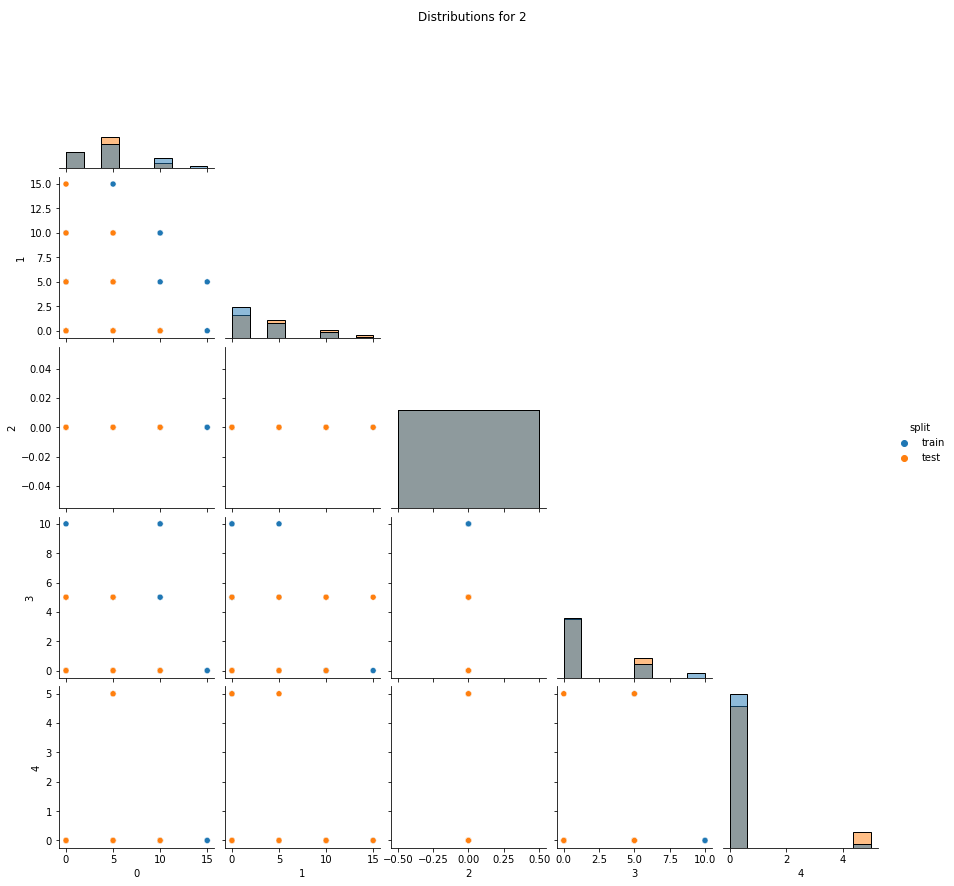

In [15]:
class_plots(df_preprocessing, cols_to_use, labels_set)

# Feature Extraction

In [16]:
fe_steps = [f"feature_extraction__{step}"
            for step in cfg.pipeline.pipeline_arch.feature_extraction]

In [17]:
fe_dfs = [exp_pipe.processed_data_df(step) for step in fe_steps]

In [18]:
cols_to_uses = [col_filter(df, k, []) for df in fe_dfs]

# Class Plots

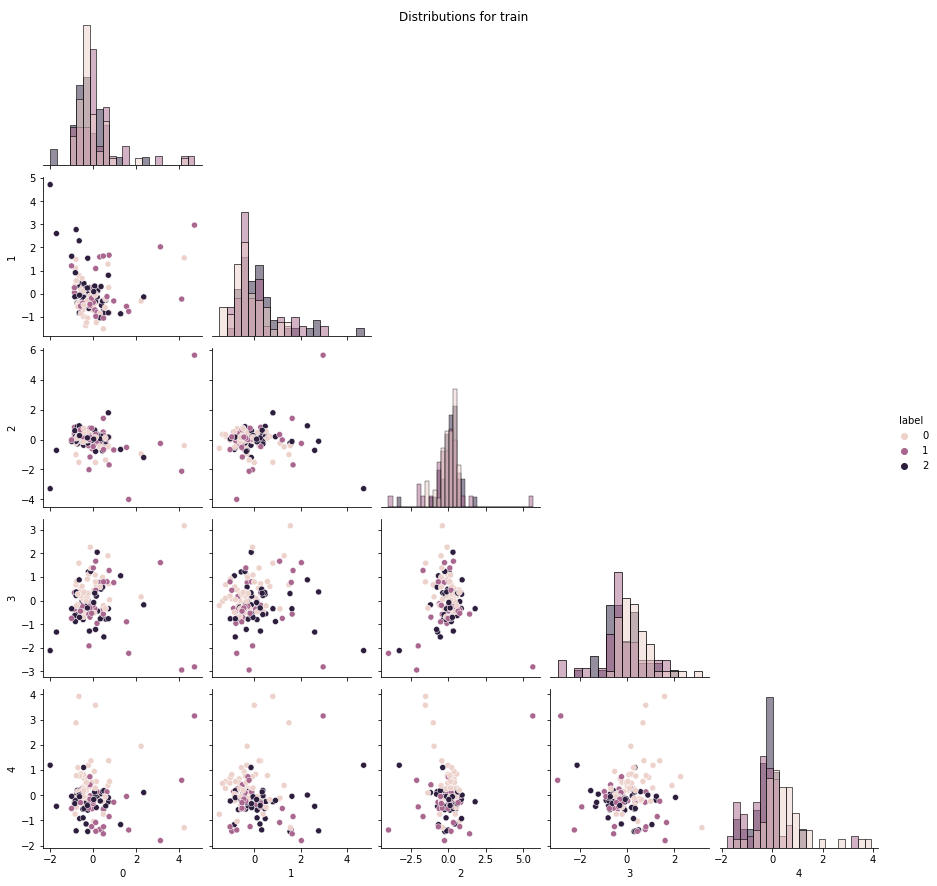

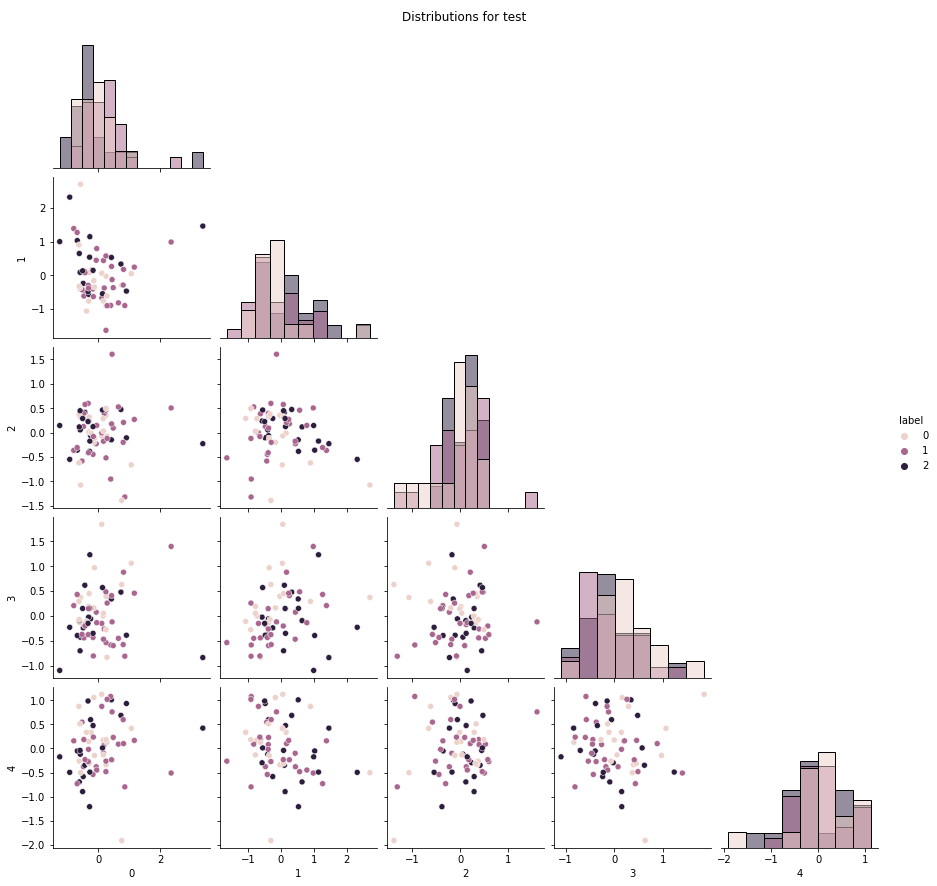

In [19]:
for df, cols in zip(fe_dfs, cols_to_uses):
    split_plots(df, cols, data_dict)

# Split Plots

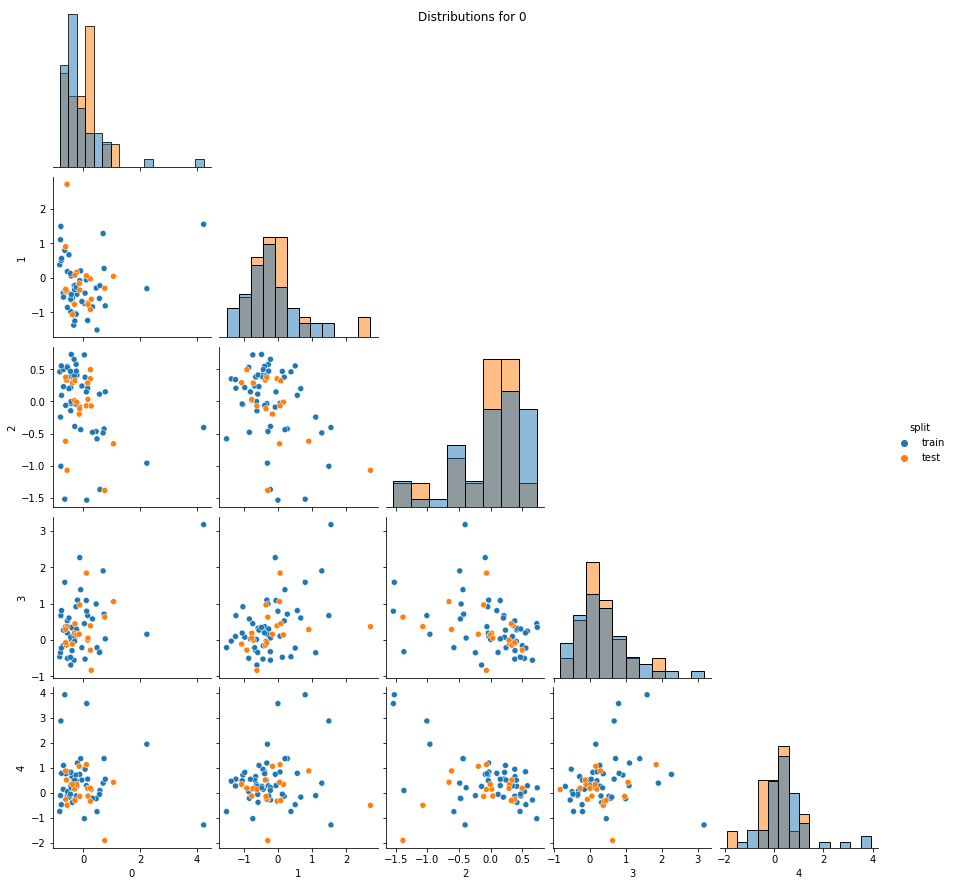

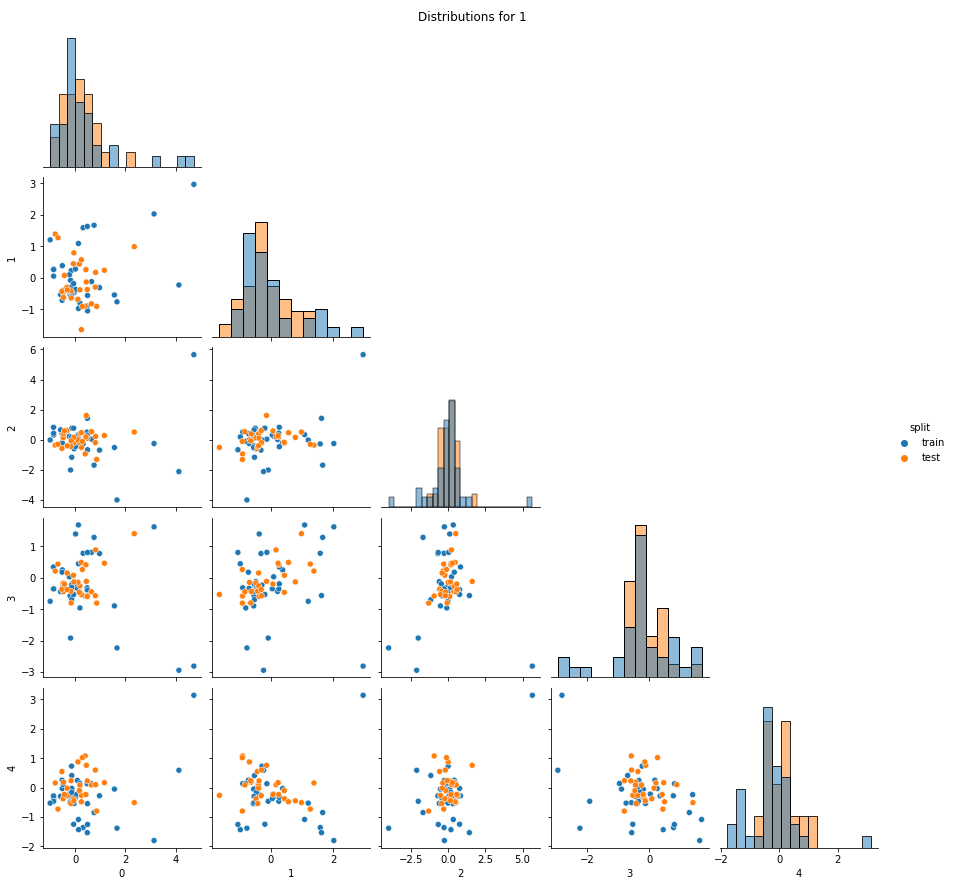

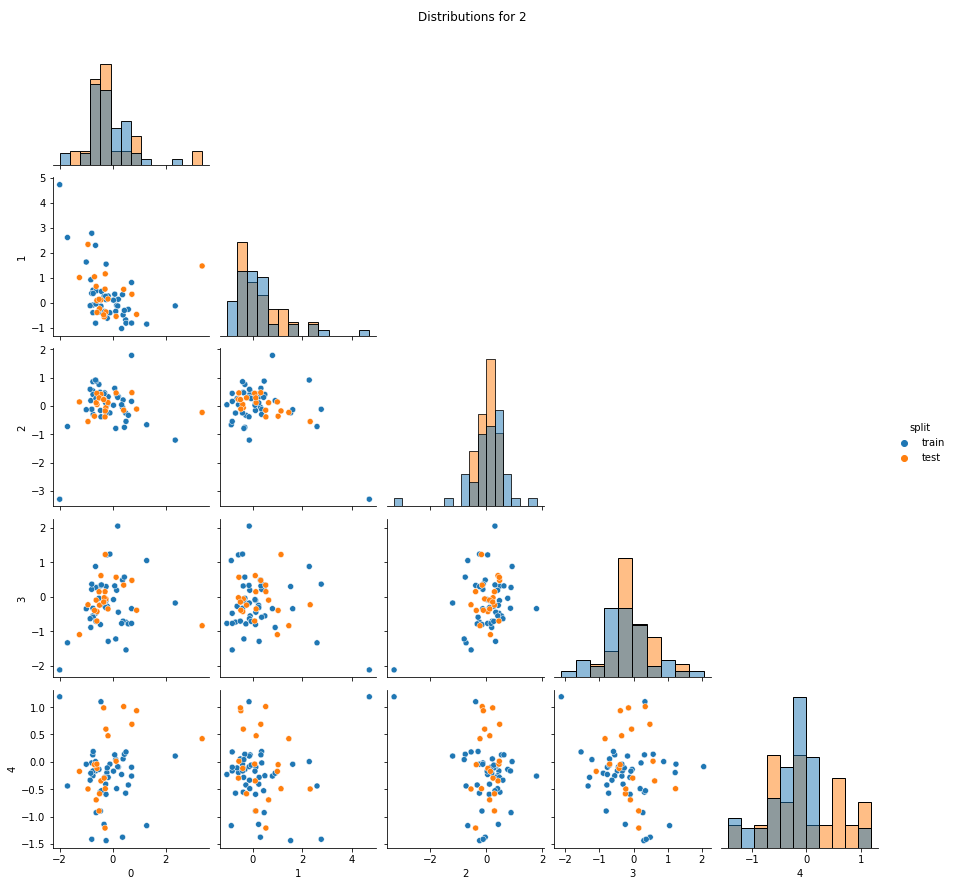

In [20]:
for df, cols in zip(fe_dfs, cols_to_uses):
    class_plots(df, cols, labels_set)

# Visualize Embeddings

In [21]:

# def get_embeddings_plot(data_dict, dict_key):
#     label_type, split = dict_key.split("_")
#     data = data_dict[dict_key]
#     opacity = 1 if split == "Train" else 0.5
#     return go.Scatter(
#         mode='markers',
#         x = data[:,0],
#         y = data[:,1],
#         opacity = opacity ,
# #         marker=dict(
# #             color= int(label_type),
# #             size= 10,
# #             line=dict(
# #                 color='MediumPurple',
# #                 width=2
# #             )
# #         ),
#         name = dict_key
#     )

# Interactive Plots

In [22]:
# import plotly.graph_objects as go


# # Build figure
# fig = go.Figure()

# for data_key in embeddings_dict_filtered.keys():
#     fig.add_trace(
#          get_embeddings_plot(
#              embeddings_dict_filtered,
#              data_key
#          )
#     )


# fig.show()
